In [1]:
import os
import torch
import json
import h5py
import random
import numpy as np
from matplotlib.pyplot import imshow
from PIL import Image, ImageDraw

In [2]:
# load the following to files from DETECTED_SGG_DIR
custom_prediction = json.load(open('../datasets/custom-data/checkpoints/motifs-tde/custom_prediction.json'))
custom_data_info = json.load(open('../datasets/custom-data/checkpoints/motifs-tde/custom_data_info.json'))

In [3]:
def draw_single_box(pic, box, color='red', draw_info=None):
    draw = ImageDraw.Draw(pic)
    x1,y1,x2,y2 = int(box[0]), int(box[1]), int(box[2]), int(box[3])
    draw.rectangle(((x1, y1), (x2, y2)), outline=color)
    if draw_info:
        draw.rectangle(((x1, y1), (x1+50, y1+10)), fill=color)
        info = draw_info
        draw.text((x1, y1), info)
        
def print_list(name, input_list, scores=None):
    for i, item in enumerate(input_list):
        if scores == None:
            print(name + ' ' + str(i) + ': ' + str(item))
        else:
            print(name + ' ' + str(i) + ': ' + str(item) + '; score: ' + str(scores[i]))
    
def draw_image(img_path, boxes, box_labels, rel_labels, box_scores=None, rel_scores=None, save_image=False):
    size = get_size(Image.open(img_path).size)
    pic = Image.open(img_path).resize(size)
    num_obj = len(boxes)
    for i in range(num_obj):
        info = str(i) + '_' + box_labels[i]
        draw_single_box(pic, boxes[i], draw_info=info)
    display(pic)

    save_path = img_path.split('/')[-1]

    
    if save_image == True:
        pic.save(f'./sgg-output-images/motifs-tde/{save_path}', 'JPEG' )

    print('*' * 50)
    print_list('box_labels', box_labels, box_scores)
    print('*' * 50)
    print_list('rel_labels', rel_labels, rel_scores)
    
    return None

def get_size(image_size):
    min_size = 600
    max_size = 1000
    w, h = image_size
    size = min_size
    if max_size is not None:
        min_original_size = float(min((w, h)))
        max_original_size = float(max((w, h)))
        if max_original_size / min_original_size * size > max_size:
            size = int(round(max_size * min_original_size / max_original_size))
    if (w <= h and w == size) or (h <= w and h == size):
        return (w, h)
    if w < h:
        ow = size
        oh = int(size * h / w)
    else:
        oh = size
        ow = int(size * w / h)
    return (ow, oh)

In [6]:
# parameters
# image_idx = 29
image_idx = 29
box_topk = 30 # select top k bounding boxes
rel_topk = 20 # select top k relationships

ind_to_classes = custom_data_info['ind_to_classes']
ind_to_predicates = custom_data_info['ind_to_predicates']

[['/workspace/datasets/custom-data/40-custom-images/20170224_1007_32.jpg', [('room', 'has', 'handle'), ('man', 'at', 'table'), ('desk', 'in', 'room'), ('cabinet', 'behind', 'man'), ('drawer', 'in', 'room'), ('desk', 'in', 'room'), ('drawer', 'under', 'bottle'), ('cabinet', 'in', 'room'), ('desk', 'has', 'handle'), ('man', 'has', 'head'), ('table', 'in', 'room'), ('shirt', 'at', 'table'), ('man', 'has', 'face'), ('man', 'at', 'desk'), ('drawer', 'in', 'room'), ('cabinet', 'in', 'room'), ('desk', 'has', 'handle'), ('table', 'has', 'handle'), ('shirt', 'at', 'desk'), ('cabinet', 'has', 'handle')]], ['/workspace/datasets/custom-data/40-custom-images/20220718_1123_85.jpg', [('man', 'has', 'leg'), ('man', 'has', 'leg'), ('rock', 'under', 'roof'), ('rock', 'under', 'roof'), ('rock', 'under', 'roof'), ('rock', 'under', 'roof'), ('building', 'has', 'door'), ('rock', 'under', 'roof'), ('building', 'has', 'door'), ('man', 'has', 'face'), ('rock', 'under', 'tower'), ('man', 'has', 'head'), ('rock'

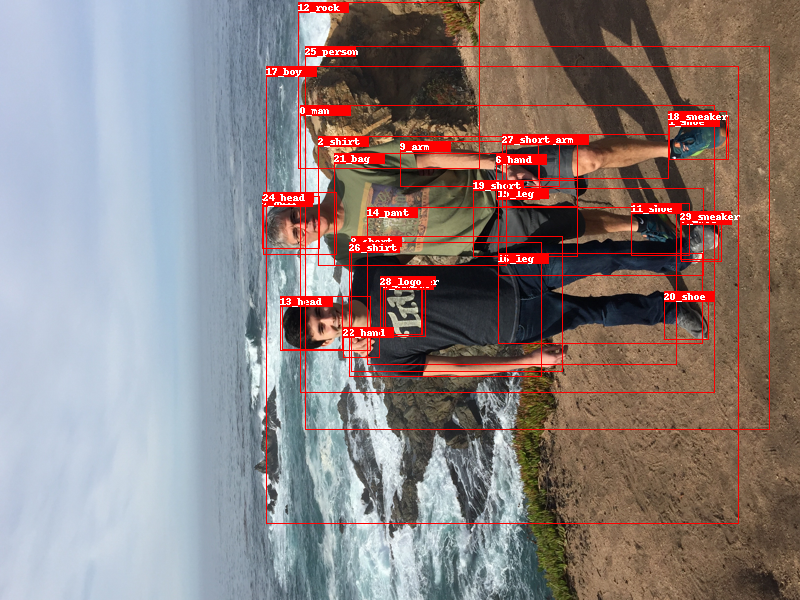

**************************************************
box_labels 0: man; score: 0.6950300335884094
box_labels 1: shoe; score: 0.6945158243179321
box_labels 2: shirt; score: 0.4926491975784302
box_labels 3: hair; score: 0.40757516026496887
box_labels 4: hair; score: 0.3505173623561859
box_labels 5: number; score: 0.3171803057193756
box_labels 6: hand; score: 0.31175729632377625
box_labels 7: shoe; score: 0.3104225993156433
box_labels 8: short; score: 0.2501387298107147
box_labels 9: arm; score: 0.24848529696464539
box_labels 10: arm; score: 0.24577362835407257
box_labels 11: shoe; score: 0.2241048365831375
box_labels 12: rock; score: 0.22317996621131897
box_labels 13: head; score: 0.22229109704494476
box_labels 14: pant; score: 0.18877044320106506
box_labels 15: leg; score: 0.11568395048379898
box_labels 16: leg; score: 0.11565733700990677
box_labels 17: boy; score: 0.11131410300731659
box_labels 18: sneaker; score: 0.08272083848714828
box_labels 19: short; score: 0.0822211354970932
box_la

In [7]:
image_dir = '../datasets/custom-data/40-custom-images/'
img_sg_tuples = []
for image_idx in range(len(os.listdir(image_dir))):
    image_path = custom_data_info['idx_to_files'][image_idx]
    boxes = custom_prediction[str(image_idx)]['bbox'][:box_topk]
    box_labels = custom_prediction[str(image_idx)]['bbox_labels'][:box_topk]
    box_scores = custom_prediction[str(image_idx)]['bbox_scores'][:box_topk]
    all_rel_labels = custom_prediction[str(image_idx)]['rel_labels']
    all_rel_scores = custom_prediction[str(image_idx)]['rel_scores']
    all_rel_pairs = custom_prediction[str(image_idx)]['rel_pairs']
    
    for i in range(len(box_labels)):
        box_labels[i] = ind_to_classes[box_labels[i]]
    
    
    # storing predicted relations in tuple form
    rel_label_tuple = []
    rel_score_tuple = []
    
    for i in range(len(all_rel_pairs)):
        if all_rel_pairs[i][0] < box_topk and all_rel_pairs[i][1] < box_topk:
            rel_score_tuple.append(all_rel_scores[i])
            # Modify the label formatting here to tuple format
            label = (box_labels[all_rel_pairs[i][0]], ind_to_predicates[all_rel_labels[i]], box_labels[all_rel_pairs[i][1]])
            rel_label_tuple.append(label)
    
    rel_label_tuple = rel_label_tuple[:rel_topk]
    rel_score_tuple = rel_score_tuple[:rel_topk]
    
    
    
    img_rel_label = rel_label_tuple
    # print(f"{image_path}", img_rel_label)

    img_sg_tuples.append([image_path, img_rel_label])
                         
print(img_sg_tuples)


# original code from sg-benchmark (produce triplets with confidence levels)
rel_labels = []
rel_scores = []
for i in range(len(all_rel_pairs)):
    if all_rel_pairs[i][0] < box_topk and all_rel_pairs[i][1] < box_topk:
        rel_scores.append(all_rel_scores[i])
        label = str(all_rel_pairs[i][0]) + '_' + box_labels[all_rel_pairs[i][0]] + ' => ' + ind_to_predicates[all_rel_labels[i]] + ' => ' + str(all_rel_pairs[i][1]) + '_' + box_labels[all_rel_pairs[i][1]]
        rel_labels.append(label)
rel_labels = rel_labels[:rel_topk]
rel_scores = rel_scores[:rel_topk]

draw_image(image_path, boxes, box_labels, rel_labels, box_scores=box_scores, rel_scores=rel_scores, save_image=True)